# Severity Classification Models for Traffic Accidents
In this notebook, classification models for the severity of traffic crashes will be developed.

In [1]:
from google.colab import drive
import sys

# Mount Google Drive
drive.mount('/content/drive')

# Get the absolute path of the current folder
abspath_curr = '/content/drive/My Drive/Capstone/'

%cd $abspath_curr

Mounted at /content/drive
/content/drive/My Drive/Capstone


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from toolbox import *

## Read Dataset
The dataset is obtained from Chicago Data Potal.

In [3]:
# Read the data
df_train = pd.read_csv("Data/train_us.csv", index_col=False)
df_val = pd.read_csv("Data/val.csv", index_col=False)
df_test = pd.read_csv("Data/test.csv", index_col=False)

### Model Development - Decision Tree

Encoding the categorical features

In [4]:
df_train_x = df_train.drop(columns=["Severity"])
y_train = df_train["Severity"].values

df_val_x = df_val.drop(columns=["Severity"])
y_val = df_val["Severity"].values

df_test_x = df_test.drop(columns=["Severity"])
y_test = df_test["Severity"].values

In [5]:
# Concat feature matrics
df_X = pd.concat([df_train_x, df_val_x, df_test_x], sort=False)
#df_X = df_X.drop(columns=["ALIGNMENT", "ROAD_DEFECT", 'WEATHER_CONDITION', 'ROADWAY_SURFACE_COND'])

#### Encoding cyclic categorical features
* "CRASH_DATE_month", "CRASH_DATE_hour", and "CRASH_DAY_OF_WEEK" are categorical, but also are cyclical.
* Encoding these feature by One-Hot encoding (OHE) will lead to the increase of the demension, which is not prefereable. In addition, the OHE cannot capture the cyclic characteristic in these features. Therefore, encoding utilized trigonometric functions will be applied.

In [6]:
df_X = cyclic_encoding(df_X, ["CRASH_DATE_month", "CRASH_DATE_hour", "CRASH_DAY_OF_WEEK"])

#### Encoding other catogorical features
* Encoding other categorical features than cyclic ones by OHE

In [7]:
df_X = df_X.astype({"POSTED_SPEED_LIMIT": float, "NUM_UNITS": float, "LATITUDE": float, "LONGITUDE": float})

In [8]:
df_X = pd.get_dummies(df_X, drop_first=True)

In [9]:
df_train_x = df_X.iloc[:df_train_x.shape[0], :]
df_val_x = df_X.iloc[df_train_x.shape[0] : df_train_x.shape[0] + df_val_x.shape[0], :]
df_test_x = df_X.iloc[df_train_x.shape[0] + df_val_x.shape[0]:, :]

### Hyperparameter Tuning

In [10]:
X_train = df_train_x.values
X_val = df_val_x.values
X_test = df_test_x.values

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# The DecisionTreeClassifier
dtc = DecisionTreeClassifier(class_weight='balanced', random_state=6501)

# Get the predefined split cross-validator
X_train_val, y_train_val, ps = get_train_val_ps(X_train, y_train, X_val, y_val)

# Create parameter grid
param_grid = {"min_samples_split": [2, 3, 4],
              "min_samples_leaf": [100, 200, 300]
             }

# The list of [best_score_, best_params_, best_estimator_] obtained by GridSearchCV
best_score_params_estimator_gs = []

# GridSearchCV
gs = GridSearchCV(estimator=dtc,
                  param_grid=param_grid,
                  scoring='f1_macro',
                  n_jobs=2,
                  cv=ps,
                  return_train_score=True)

# Fit the pipeline
gs = gs.fit(X_train_val, y_train_val)

# Update best_score_params_estimator_gs
best_score_params_estimator_gs.append([gs.best_score_, gs.best_params_, gs.best_estimator_])

# Sort best_score_params_estimator_gs in descending order of the best_score_
best_score_params_estimator_gs = sorted(best_score_params_estimator_gs, key=lambda x : x[0], reverse=True)

# Print best_score_params_estimator_gs
pd.DataFrame(best_score_params_estimator_gs, columns=['best_score', 'best_param', 'best_estimator'])

,best_score,best_param,best_estimator
0,0.399155,"{'min_samples_leaf': 100, 'min_samples_split': 2}",DecisionTreeClassifier(class_weight='balanced'...


In [20]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def display_metrics(model, X, y):
    y_pred = model.predict(X)

    accuracy = accuracy_score(y, y_pred)
    recall = recall_score(y, y_pred, average='macro')
    precision = precision_score(y, y_pred, average='macro')
    f1 = f1_score(y, y_pred, average='macro')

    print("Accuracy:", accuracy)
    print("Recall:", recall)
    print("Precision:", precision)
    print("F1 Score:", f1)

In [21]:
dtc_best = gs.best_estimator_
display_metrics(dtc_best, X_test, y_test)

Accuracy: 0.5847592825039478
Recall: 0.557407859337836
Precision: 0.42080164126545466
F1 Score: 0.3807957391177285


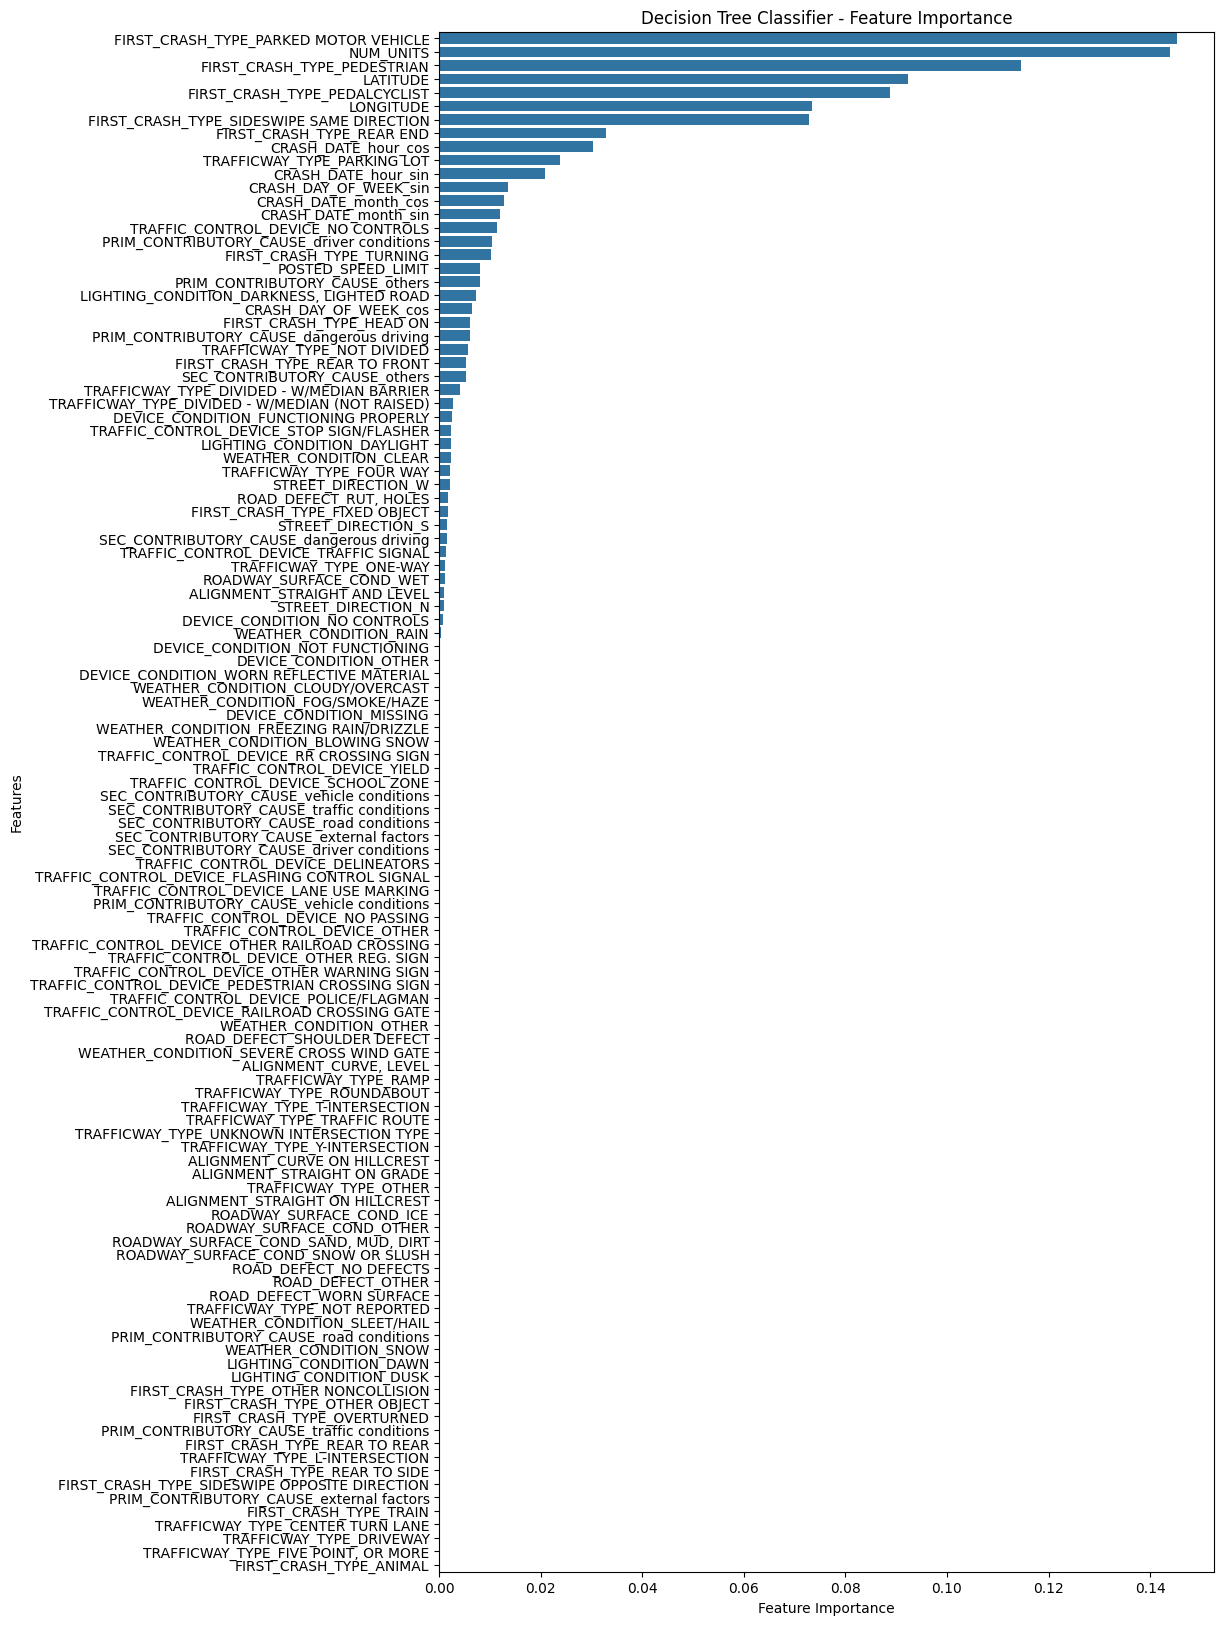

In [22]:
importances = dtc_best.feature_importances_

indices = np.argsort(importances)[::-1]
sorted_features = [df_train_x.columns[i] for i in indices]
sorted_importances = importances[indices]

plt.figure(figsize=(10, 20))
sns.barplot(x=sorted_importances, y=sorted_features)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Decision Tree Classifier - Feature Importance')
plt.show()